The aim of the model is to develop an AI system that distinguishes between fruits and vegetables for sale in open markets. It also identifies less visually appealing produce for donation to various charitable organizations and NGOs. This ensures the judicious utilization of fruits and vegetables, minimizing wastage. Ultimately, it contributes to broader objectives such as zero hunger and food security.

# importing necessary models

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
# we are using VGG16 as a base model upon which AI will be trained
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
pretrained_model = VGG16(weights="imagenet")
pretrained_model.summary()




Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

## creating a new model based on Pre trained model

In [3]:
#mode is named as model_fruits
model_fruits = Sequential()
for layers in pretrained_model.layers[:-1]:
    layers.trainable = False
    model_fruits.add(layers)
model_fruits.add(Dense(2, activation = "sigmoid"))
model_fruits.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

## creating a database of images

In [4]:
donate = r"E:\ai_project_images\donate\*"
sell = r"E:\ai_project_images\for_sale\*"

In [5]:
# glob is the module that will import all the images at onces
import glob
x = []
y = []

for image_path in glob.glob(sell):
    input_img = load_img(image_path, target_size = (224, 224))
    input_img = np.array(input_img)
    #input_img = input_img.reshape(1,224,224,3)
    input_img = preprocess_input(input_img)
    x.append(input_img)
    y.append(0) # 0 for sell, 1 for donate

for image_path in glob.glob(donate):
    input_img = load_img(image_path, target_size = (224,224))
    input_img = np.array(input_img)
    #input_img = input_img.reshape(1,224,224,3)
    input_img = preprocess_input(input_img)
    x.append(input_img)
    y.append(1)

In [6]:
#converting dataset into array
x = np.array(x)
y = np.array(y)

In [7]:
#importing train test split to divide the data into test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=44)

In [8]:
#converting the labels to categorical datasets for better model building
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

In [9]:
#checking out the datasets
print(f"shape of x_train: {x_train.shape}")
print(f"shape of x_test : {x_test.shape}")
print(f"shape of y_train: {y_train_ohe.shape}")
print(f"shape of y_test : {y_test_ohe.shape}")

shape of x_train: (960, 224, 224, 3)
shape of x_test : (241, 224, 224, 3)
shape of y_train: (960, 2)
shape of y_test : (241, 2)


## model_building

In [10]:
#importing adam from keras to hypertune the model
from tensorflow.keras.optimizers import Adam

In [11]:
lr = 0.009
model_fruits.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate = lr), metrics="accuracy")

In [12]:
model_fruits.fit(x = x_train, y = y_train_ohe, validation_data=(x_test, y_test_ohe), shuffle = True)



30/30 [==============================] - 106s 4s/step - loss: 1.1238 - accuracy: 0.8062 - val_loss: 0.5651 - val_accuracy: 0.8755


In [13]:
from sklearn.metrics import confusion_matrix

# Predict labels for the test data
y_pred = model_fruits.predict(x_test)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_true_labels = np.argmax(y_test_ohe, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Print or visualize the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

8/8 [==============================] - 22s 3s/step
Confusion Matrix:
[[103  21]
 [  9 108]]


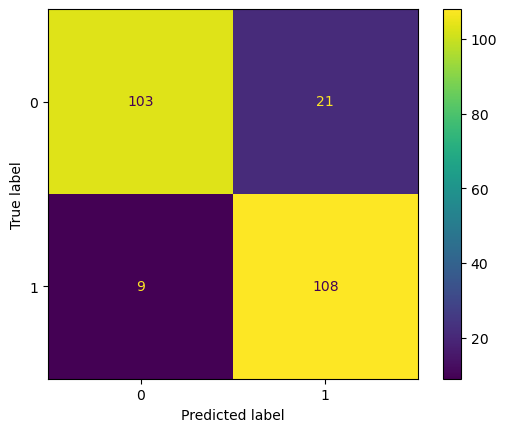

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
cm_display.plot()
plt.show()


In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_true_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       124
           1       0.84      0.92      0.88       117

    accuracy                           0.88       241
   macro avg       0.88      0.88      0.88       241
weighted avg       0.88      0.88      0.88       241



In [15]:
action_to_be_taken = {0: 'sell', 1: 'donate'}
action_to_be_taken = pd.DataFrame(list(action_to_be_taken.items()), columns=['Label', 'Action'])
action_to_be_taken.set_index('Label', inplace=True)

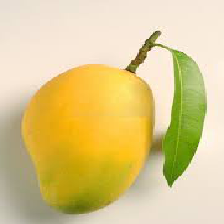

In [16]:
from keras.preprocessing.image import load_img

# Provide the path to the image file
image_for_pred = load_img(r"C:\Users\sudis\Downloads\Sell\Sell\images (96).jpeg", target_size=(224, 224))
image_for_pred

In [17]:
image_for_pred = np.array(image_for_pred)
image_for_pred = image_for_pred.reshape(1,224,224,3)
image_for_pred = preprocess_input(image_for_pred)
pred = model_fruits.predict(image_for_pred)
action_to_be_taken["pred_prob"] = np.round(pred.flatten(), 2)*100

1/1 [==============================] - 0s 168ms/step


In [19]:
# Find the index of the row with the highest 'pred' value
max_pred_index = action_to_be_taken['pred_prob'].idxmax()

# Get the label corresponding to the row with the highest 'pred' value
label_with_highest_pred = action_to_be_taken.loc[max_pred_index, 'Action']

# Print the label with the highest 'pred' value
print("We recomend it to", label_with_highest_pred)

We recomend it to sell
